# Muon Lifetime Lab
### Miles Lucas - Phys 322L - Iowa State University

This lab seeks to find the mean life of cosmic muons incident on Earth's surface. Theoretically, this relationship can be represented by 
$$
N(t) = N = N_0 e^{-k\cdot t}
$$

The mean life of the muon is $\tau_0 = 1 / k$ where $k$ can be found via the following data analysis

In [1]:
# Imports and parameter setting

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
plt.style.use('seaborn-notebook')

output=False

if output:
    width = 3.404
    height = width * .9
    params = {
        'xtick.labelsize':8,
        'ytick.labelsize':8,
        'axes.labelsize':8,
        'legend.fontsize':8,
        'font.family':'serif',
    }
    mpl.rcParams.update(params)

## Calibration Data

Because all of our timed data is binned by the signal interface into channels, we had to find the relationship between bin number and time. Using a delay module, we introduced known delays and correlated them to bin number. The following data finds a linear fit so that we can find the time interval associated with every channel for later analysis

In [2]:
try:
    calib = pd.read_csv('data/calib.csv', header=0, names=['Interval', 'Channel'])
except FileNotFoundError:
    print('Calibration file not found')

In [3]:
res = smf.ols('Interval ~ Channel', data=calib).fit()
print(res.summary())
res.params
b, a = res.params
f = lambda c: a * c + b

                            OLS Regression Results                            
Dep. Variable:               Interval   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.639e+04
Date:                Thu, 27 Apr 2017   Prob (F-statistic):           3.09e-26
Time:                        22:21:02   Log-Likelihood:                 43.574
No. Observations:                  15   AIC:                            -83.15
Df Residuals:                      13   BIC:                            -81.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1182      0.008    -14.617      0.0

C:\Users\drumm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


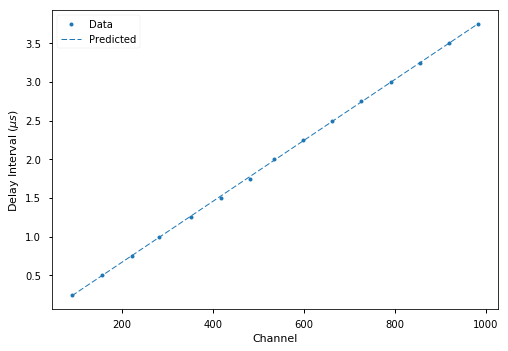

In [4]:
plt.xlabel('Channel')
plt.ylabel('Delay Interval ($\mu s$)')

prstd, iv_l, iv_u = wls_prediction_std(res)

plt.plot(calib['Channel'], calib['Interval'], 'C0o', ms=4,label='Data')
plt.plot(calib['Channel'], res.fittedvalues, 'C0--', linewidth=1, label='Predicted')
# plt.fill_between(calib['Channel'], iv_l, iv_u, alpha=.5, color='C0')
plt.legend(loc='best');

if output:
    plt.gcf().set_size_inches(width, height)
    plt.tight_layout()
    plt.savefig('figs/calib.pdf')

## Applying to data

Now that we know the time intervals for each channel, we import our data and look at the relationship between counts and time. This ought to be an exponential relationship from our theoretical model. However, it is much more accurate to use a linear fit for our analysis, as non-linear fits can be very erratic. Our model is easy to linearize, though. Our model can be transformed into this linear model
$$
ln(N) = ln(N_0 e^{-k t}) = -kt + ln(N_0)
$$
When we do a linear fit for this model, we see that our slope is $-k$, and the intercept is $ln(N_0)$. 

One problem with our data, though, is that there are many counts of 0, which have no logarithmic value. To combat this, we do two things. First, we remove all the zeros at the head of the dataset, which is okay because a pure exponential decay will naturally start at its highest value and won't ramp up from some value. Second, we apply an exponentially-weighted moving average. This allows the zero-counts at the tail of the data to affect our fit (as opposed to just remove all 0-count entries) without running into issues with finding the logarithm of 0.

In [5]:
try:
    run1 = pd.read_csv('data/Exp3_Tue_1day_RUN1.csv', header=0)
    run2 = pd.read_csv('data/Exp3_Tue_4day_RUN2.csv', header=0)
    run3 = pd.read_csv('data/Exp3_Tue_3wk_RUN3.csv', header=0)
except FileNotFoundError:
    print('Data file not found')

#Combine data files
test_data = run1.copy()
test_data['Counts'] = test_data['Counts'] + run2['Counts'] + run3['Counts']
    
# Get first non-zero count, start data series from here
test_data['Time'] = f(test_data['Channel'])
nzi = next((i for i, x in enumerate(test_data['Counts']) if x>0.0), None)
test_data = test_data[(test_data.index > nzi)]

test_data['ewma'] = test_data['Counts'].ewm(span=max(test_data['Time'])).mean()

In [6]:
res2 = smf.ols(formula='np.log(ewma) ~ Time', data=test_data).fit()
print(res2.summary())

A, k = res2.params
c = -1/k

                            OLS Regression Results                            
Dep. Variable:           np.log(ewma)   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 7.965e+04
Date:                Thu, 27 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:21:02   Log-Likelihood:                 703.68
No. Observations:                2012   AIC:                            -1403.
Df Residuals:                    2010   BIC:                            -1392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.4481      0.008    582.225      0.0

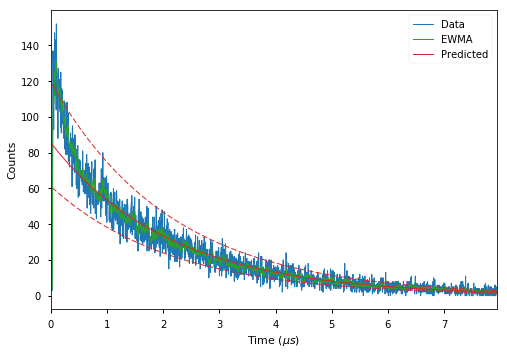

In [7]:
plt.xlim(0,max(test_data['Time']))
plt.xlabel('Time ($\mu s$)')
plt.ylabel('Counts')

prstd, iv_l, iv_u = np.exp(wls_prediction_std(res2))
t = test_data['Time']

plt.plot(t, test_data['Counts'], linewidth=1, label='Data')
plt.plot(t, test_data['ewma'], c='C2', linewidth=1, label='EWMA')
plt.plot(t, np.exp(res2.fittedvalues), c='C3', linewidth=1, label='Predicted')
# plt.fill_between(t, iv_l, iv_u, alpha=0.50, color='C3', linewidth=1)
plt.plot(t, iv_u, 'C3--', linewidth=1)
plt.plot(t, iv_l, 'C3--', linewidth=1)
plt.legend(loc='best')

if output:
    plt.gcf().set_size_inches(width, height)
    plt.tight_layout()
    plt.gcf().savefig('figs/data_fit.pdf')

## Issues with above data
We can see that our data does not seem to be truly exponential, due to either an electronics error or some relativistic effect. The simplest way we subdue this effect is to just cut values below 1 $\mu s$. Below we run the same analysis over the truncated data

In [27]:
trunc_data = test_data[test_data['Time'] > 1]

res3 = smf.ols(formula='np.log(ewma) ~ Time', data=trunc_data).fit()
print(res3.summary())

A2, k2 = res3.params
c2 = -1/k2

                            OLS Regression Results                            
Dep. Variable:           np.log(ewma)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 7.176e+04
Date:                Thu, 27 Apr 2017   Prob (F-statistic):               0.00
Time:                        23:39:58   Log-Likelihood:                 931.15
No. Observations:                1764   AIC:                            -1858.
Df Residuals:                    1762   BIC:                            -1847.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.3654      0.008    525.347      0.0

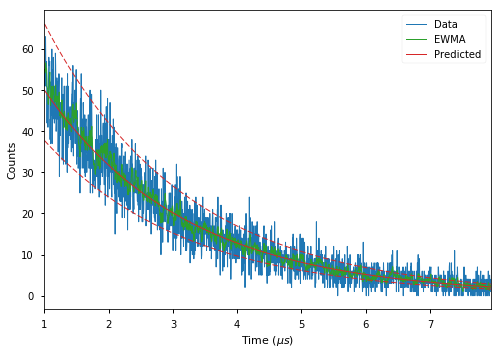

In [28]:
plt.xlim(1,max(trunc_data['Time']))
plt.xlabel('Time ($\mu s$)')
plt.ylabel('Counts')

prstd, iv_l, iv_u = np.exp(wls_prediction_std(res3))
t = trunc_data['Time']

plt.plot(t, trunc_data['Counts'], linewidth=1, label='Data')
plt.plot(t, trunc_data['ewma'], c='C2', linewidth=1, label='EWMA')
plt.plot(t, np.exp(res3.fittedvalues), c='C3', linewidth=1, label='Predicted')
# plt.fill_between(t, iv_l, iv_u, alpha=0.50, color='C3', linewidth=1)
plt.plot(t, iv_u, 'C3--', linewidth=1)
plt.plot(t, iv_l, 'C3--', linewidth=1)
plt.legend(loc='best')

if output:
    plt.gcf().set_size_inches(width, height)
    plt.tight_layout()
    plt.gcf().savefig('figs/data_fit_trunc.pdf')

In [29]:
actual = 2.22
error = np.abs(actual - c) / actual * 100
uncertainty = 1/(-k + res2.bse['Time']) - 1/(-k - res2.bse['Time'])
print('Run with all values:')
print('Time constant fit value: {:.3f}+-{:.3f}\nTime constant actual value: {}\nError: {:.1f}%'.format(c, np.abs(uncertainty), actual, error))

Run with all values:
Time constant fit value: 2.131+-0.015
Time constant actual value: 2.22
Error: 4.0%


In [24]:
error2 = np.abs(actual - c2) / actual * 100
uncertainty2 = 1/(-k2 + res3.bse['Time']) - 1/(-k2 - res3.bse['Time'])
print('Run with values t>1.0 microseconds:')
print('Time constant fit value: {:.3f}+-{:.3f}\nTime constant actual value: {}\nError: {:.1f}%'.format(c2, np.abs(uncertainty2), actual, error2))

Run with values t>1.0 microseconds:
Time constant fit value: 2.203+-0.016
Time constant actual value: 2.22
Error: 0.8%
